In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
!pip install shap
import shap
from itertools import combinations




In [ ]:
def train_evaluate_and_plot_roc(df, target_column, feature_sets, parameter_grid, n_splits=7):

    scaler = StandardScaler()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    plt.figure(figsize=(10, 6))
    metrics_list = []

    for feature_columns in feature_sets:

        metrics = {
            'Feature Set': [', '.join(feature_columns)],
            'AUC': [],
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1 Score': [],
            'Specificity': [],
            'NPV': []
        }


        X = df[feature_columns]
        y = df[target_column]

        X_scaled = scaler.fit_transform(X)

        auc_scores = []
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        specificity_scores = []
        npv_scores = []
        tprs = []
        mean_fpr = np.linspace(0, 1, 100)


        for train_index, test_index in kf.split(X_scaled):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]


            grid_search = GridSearchCV(MLPClassifier(max_iter=2000), param_grid=parameter_grid, cv=7, scoring='roc_auc')
            grid_search.fit(X_train, y_train)
            best_mlp_model = grid_search.best_estimator_


            y_pred_prob = best_mlp_model.predict_proba(X_test)[:, 1]


            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0


            roc_auc = roc_auc_score(y_test, y_pred_prob)
            auc_scores.append(roc_auc)


            y_pred = best_mlp_model.predict(X_test)
            accuracy_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred))
            recall_scores.append(recall_score(y_test, y_pred))
            f1_scores.append(f1_score(y_test, y_pred))

            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            specificity = tn / (tn + fp)
            npv = tn / (tn + fn)
            specificity_scores.append(specificity)
            npv_scores.append(npv)

        # Compute average ROC AUC
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = np.mean(auc_scores)


        plt.plot(mean_fpr, mean_tpr, label=f'{", ".join(feature_columns)} (AUC = {mean_auc:.2f})')

        # Calculate mean scores
        metrics['AUC'].append(mean_auc)
        metrics['Accuracy'].append(np.mean(accuracy_scores))
        metrics['Precision'].append(np.mean(precision_scores))
        metrics['Recall'].append(np.mean(recall_scores))
        metrics['F1 Score'].append(np.mean(f1_scores))
        metrics['Specificity'].append(np.mean(specificity_scores))
        metrics['NPV'].append(np.mean(npv_scores))

        metrics_list.append(metrics)


    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random Guessing')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='lower right')
    plt.show()

    # Create DataFrame from metrics dictionary
    evaluation_metrics = pd.concat([pd.DataFrame(m) for m in metrics_list], ignore_index=True)

    # Save evaluation_metrics to Excel file
    evaluation_metrics.to_excel('evaluation_metrics.xlsx', index=False)

    return evaluation_metrics


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

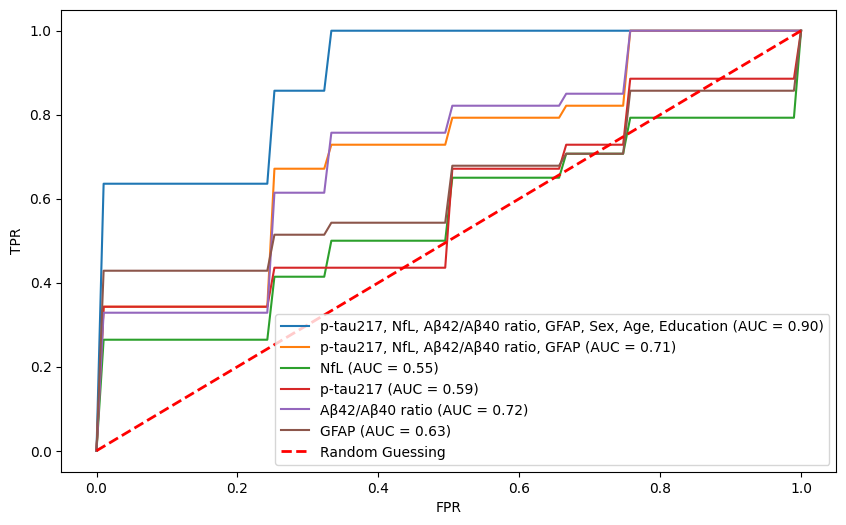

,Feature Set,AUC,Accuracy,Precision,Recall,F1 Score,Specificity,NPV
0,"p-tau217, NfL, Aβ42/Aβ40 ratio, GFAP, Sex, Age...",0.897024,0.914683,0.923810,0.942857,0.926407,0.880952,0.935714
1,"p-tau217, NfL, Aβ42/Aβ40 ratio, GFAP",0.713690,0.621032,0.667347,0.685714,0.659307,0.547619,0.633333
2,NfL,0.549405,0.535714,0.551587,0.942857,0.694924,0.000000,NaN
3,p-tau217,0.588690,0.583333,0.619048,0.857143,0.695733,0.261905,NaN
4,Aβ42/Aβ40 ratio,0.717262,0.648810,0.675170,0.771429,0.703463,0.500000,0.666667
5,GFAP,0.626786,0.603175,0.661905,0.650000,0.646898,0.559524,0.545238


In [ ]:
# Define the different feature sets
feature_sets = [
    ['p-tau217', 'NfL', 'Aβ42/Aβ40 ratio', 'GFAP', 'Sex','Age','Education'],
    ['p-tau217', 'NfL', 'Aβ42/Aβ40 ratio', 'GFAP'],
    ['NfL'],
    ['p-tau217'],
    ['Aβ42/Aβ40 ratio'],
    ['GFAP'],

]

parameter_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant']
}

train_evaluate_and_plot_roc(df_cn_vs, 'diagnosis', feature_sets, parameter_grid, n_splits=7)

#evaluation_metrics




In [ ]:
import shap


scaler = StandardScaler()


X = df_cn_vs[feature_sets[0]]
y = df_cn_vs['Diagnosis']


X_scaled = scaler.fit_transform(X)

kf = KFold(n_splits=7, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


    grid_search = GridSearchCV(MLPClassifier(max_iter=2000), param_grid=parameter_grid, cv=7, scoring='roc_auc')
    grid_search.fit(X_train, y_train)


    best_mlp_model = grid_search.best_estimator_


    explainer = shap.KernelExplainer(best_mlp_model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_test)


    shap.summary_plot(shap_values[1], X_test, feature_names=feature_sets[0])


    break




/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perce

  0%|          | 0/19 [00:00<?, ?it/s]

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.